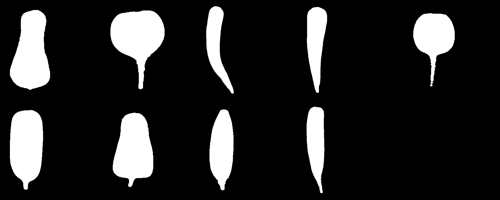

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadishLab"
# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABROOT)
    COLABORATORY = True
except ImportError:
    COLABORATORY = False
    sys.path.append('./rdlib')
    
import rdlib.rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

SilF = labhome+'/RDSamples/silhoetteM' # シルエット画像のフォルダ
SrcF = labhome+'/RDSamples/croppedM' # 原画像のフォルダ

SilFnames = rd.collectimagepaths(SilF) # シルエット画像のファイル名リスト
imgs = rd.collectimages(SilF)       # シルエット画像のリスト
simgs = rd.collectimages(SrcF)
rd.makethumbnail(SilF)

# シルエットの左右分離

ダイコンのシルエットを先端と葉の付け根部分を基準に左右に分割したい。

左右分割を考えるのは、

1. フーリエ記述子のような全周を対象とした記述方法以外の表現の応用可能性に道を開く。
2. ダイコンは（理想的には）軸対称図形であるので、左右どちらかだけでその形状とみなせる。
3. ダイコンの形状を「軸の形状」と「軸に沿った幅の変化の様子」ととらえることができる。
4. 漠然と「幅」という概念が用いられるが、幅という概念は軸という概念があってはじめて成り立つ。
5. 左右の輪郭が与えられれば、それをもとに軸を推定できる可能性がある。

など理由。

我々の思い浮かべるダイコンの形状は軸対称であり、実際の個体には曲がりがあるとしても、なんとなく、”葉の付け根”の中央から”先端”に向かう軸をイメージすることができる。

典型的な線対称の砲弾型のシルエットを思い浮かべると、自動的に軸を見つけて左右分割することは容易なように
思われるが、実際にはそう容易ではない。


## バウンディングボックスでは？
例えばバウンディングボックスの上下の辺と輪郭の接点を左右分割の基準にできないか試してみよう。

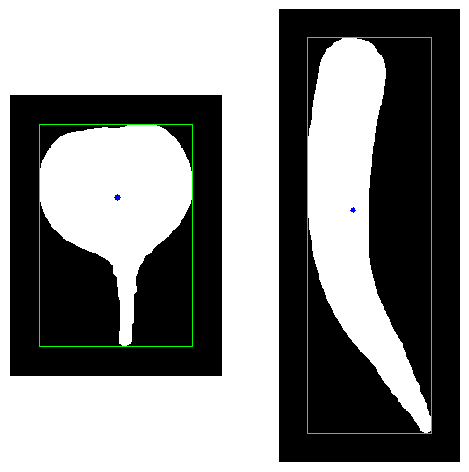

In [2]:
# 重心位置とバウンディングボックス
img0 = imgs[1].copy()
img1 = imgs[2].copy()
x0,y0,con0 = rd.getCoG(img0)
x1,y1,con1 = rd.getCoG(img1)
outimg0 = cv2.cvtColor(img0,cv2.COLOR_GRAY2BGR)
outimg1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
cv2.circle(outimg0,(int(x0),int(y0)),3,(255,0,0),-1)
cv2.rectangle(outimg0,con0,(0,255,0))
cv2.circle(outimg1,(int(x1),int(y1)),3,(255,0,0),-1)
cv2.rectangle(outimg1,con1,(0,255,0),1)
plt.figure(figsize=(6,6),dpi=100)
rd.plotimg(outimg0,layout="121")
rd.plotimg(outimg1,layout="122")

### 下端
図でわかるように、意識的に個体を縦置きで撮影してあるなら、下端はほとんどの場合はシルエットの画素の中で最も下の点というルールで決めても問題なさそうではある。ただし、末端の曲がりが大きすぎて上を向いているような場合もありえるので、そのような個体は例外処理しないといけない。

### 上端
一般に上端は下端と比べて幅がある。左の図からわかるように、最も上に位置する画素は必ずしも中心軸上端点として妥当な点ではない。



# 中心軸端点らしさの尺度

仮に図形が線対称であるとする。ある画素$P$が輪郭線上と対称軸の交点上に位置するものとしよう。点$P_i$から輪郭線に沿って反時計回りにn画素分移動した位置にある画素$P_{i-n}$と時計回りに同じ画素分移動した位置にある点$P_{i＋n}$を通る直線と、$P_{i-n}P_{i+n}$の中点$Q_{i,n}$と$P_i$を結ぶ直線とは直交する。ここで、


$$E_i = \frac{1}{N}\sum_{n=1}^{N} \frac{\left|\vec{P_i Q_{i,n}}\cdot\vec{P_{i-n}P_{i+n}}\right|}{|\vec{P_i} Q_{i,n}||\vec{P_{i-n}P_{i+n}}|}$$ 
とおくと、図形が線対称で、点$P_i$が軸上にあるのであれば、$E_i$の値は０であり、そうでなければ正の値となる。

図形が線対称でなければ、輪郭上のどの点$P_i$に対しても、評価関数$E_i$は０となることはないが、上端と下端に探索範囲を絞って、$E_i$が最小値となるような輪郭上の点をそれぞれ求めることで輪郭を左側と右側に分割してみる。


## findTips() :中心軸の両端点を求める関数

>  rd.findTips(img,con=[],top=0.1,bottom=0.9,topCD=1.0,bottomCD=0.4)

    # 入力　
    #   img シルエット画像
    #   con 輪郭点列　（なければ画像から作る）
    # パラメータ
    #   top 中心軸上端点の候補探索範囲　高さに対する割合
    #   bottom 中心軸下端点の候補探索範囲　
    #   topCD  中心軸上端点らしさの評価データを収集する範囲
    #   bottomCD 中心軸下端点らしさの評価データを収集する範囲
    # 出力
    #   con  輪郭点列
    #   topTip  中心軸上端点の輪郭番号
    #   bottomTip 中心軸下端点の輪郭番号
    #   symtops 各輪郭点の中心軸上端らしさの評価データ
    #   symbottoms 各輪郭点の中心軸下端らしさの評価データ
    


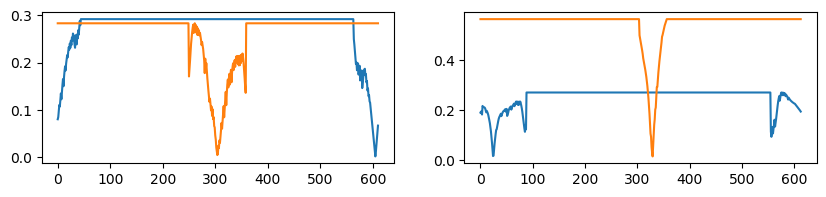

In [3]:
img0 = imgs[0].copy()
con0,topTip0,bottomTip0,symtops0,symbottoms0 = rd.findTips(img0)
img1 = imgs[1].copy()
con1,topTip1,bottomTip1,symtops1,symbottoms1 = rd.findTips(img1)

plt.figure(figsize=(10,2),dpi=100)
plt.subplot(121)
plt.plot(symtops0)
plt.plot(symbottoms0)
plt.subplot(122)
plt.plot(symtops1)
plt.plot(symbottoms1)

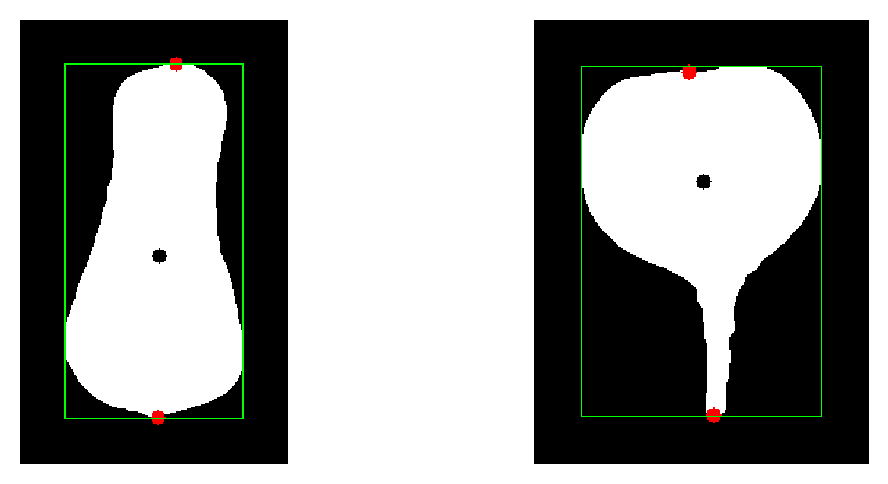

In [4]:
def plottips(img,layout='111',topCD=1.0,bottomCD=0.8):
    img = img.copy()
    con,topTip,bottomTip,symtops,symbottoms = rd.findTips(img,topCD=topCD,bottomCD=bottomCD)
    con = con.squeeze().tolist() # 輪郭点列のリスト
    gx,gy,rect = rd.getCoG(img) # 重心
    outimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    cv2.circle(outimg,(int(con[topTip][0]),int(con[topTip][1])),5,(0,0,255),-1)
    cv2.circle(outimg,(int(con[bottomTip][0]),int(con[bottomTip][1])),5,(0,0,255),-1)
    cv2.circle(outimg,(int(gx),int(gy)),5,(0,0,0),-1)
    cv2.rectangle(outimg,rect,(0,255,0),1)
    rd.plotimg(outimg,layout=layout)

plt.figure(figsize=(10,10),dpi=200)
plottips(imgs[0],layout='331')
plottips(imgs[1],layout='332')

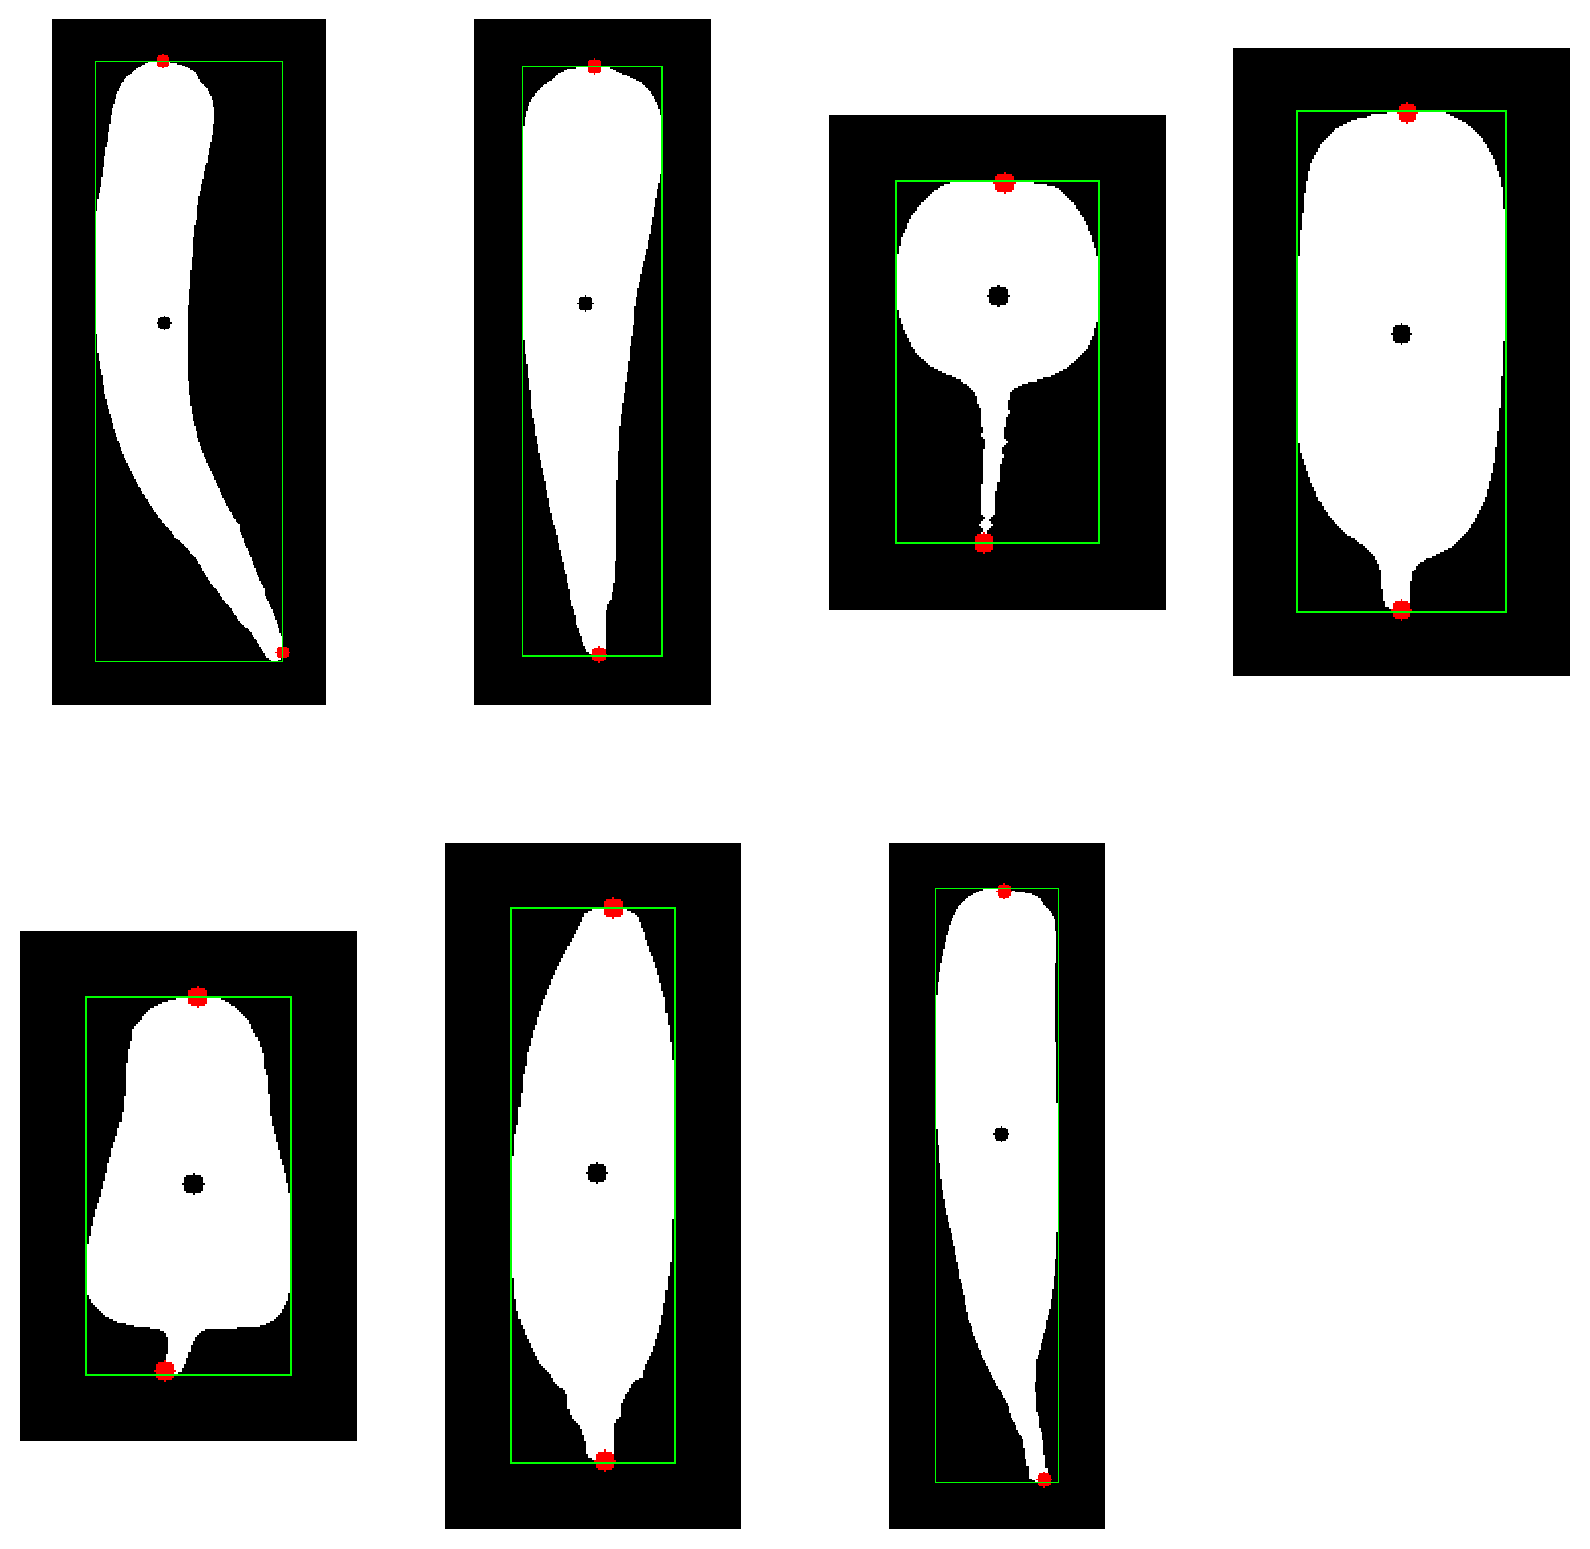

In [5]:
plt.figure(figsize=(10,10),dpi=200)
plottips(imgs[2],layout='241')
plottips(imgs[3],layout='242')
plottips(imgs[4],layout='243')
plottips(imgs[5],layout='244')
plottips(imgs[6],layout='245')
plottips(imgs[7],layout='246')
plottips(imgs[8],layout='247')

# 考察

われわれの思い浮かべる理想的なダイコンは軸対象であり、幅や長さといった概念は対称軸を仮定して初めて成立する。左右対称な図形であれば形状は形状記述はシルエットの半分を対象とすればよい。

種や個体の特徴として、”軸の湾曲”を挙げることがあるが、それも、曲がりのない左右対称を基準とした概念である。

図形が正確に線対称なのであればその対称軸は必ず重心を通るはずなので、そのような直線を候補とし、図形がその直線に対して線対称となるかどうかを判定することで、対称軸をサーチすればよい。

しかし、残念ながら現実の個体のシルエットは一般に左右対称図形ではない。対称形に変形を加えた結果が観測されているのだとしても、変形後の図形を入力として、元の左右対称図形とそれに加えられた変形操作を分離する問題は不良設定問題であり、容易ではない。

上の７つの例はデフォルトのパラメータ設定でまずまずの結果が得られているが、パラメータを少し変えるとうまくいかない個体が出てくる。

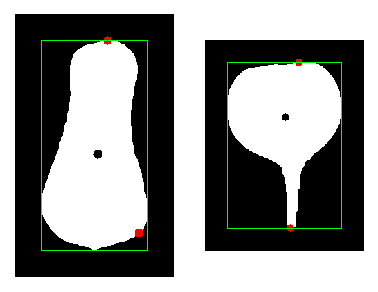

In [6]:
# 失敗例
plt.figure(figsize=(3,3),dpi=150)
plottips(imgs[0],bottomCD=0.2,layout=121)
plottips(imgs[1],topCD=0.2,layout=122)

# getCntPairWithCntImg() : 指定位置での輪郭線の左右分割

> def getCntPairWithCntImg(rdcimg,dtopx,dtopy,dbtmx,dbtmy,dtopdr=10,dbtmdr=10):
    # 入力
    #    drcimg: ダイコンの輪郭画像
    # パラメータ
    #    (dtopx,dtopy) dtopdr　上部削除円中心と半径
    #    (dbtmx,dbtmy) dbtmdr  下部削除円中心と半径
    # 出力
    #   conLeft  左輪郭構造体
    #   conRight 右輪郭構造体


# getCntPairWithImg()：ダイコン画像から左右の輪郭を得る
> def getCntPairWithImg(rdimg,top=0.1,bottom=0.9,topCD=1.0, bottomCD=0.8,topdtopdr=10,dbtmdr=10):
    # 入力
    # 　drimg: ダイコンの画像
    # パラメータ
    # 　top,bottom,topCD,bottomCD ：findTips() に与えるパラメータ
    # 　dtopdr,dbtmdr:　getCntPairWithCntImg() に与えるパラメータ
    # 出力
    #   conLeft  左輪郭構造体
    #   conRight 右輪郭構造体
    
# drawContours()：輪郭線の描画
>  drawContours(canvas,con,color=255,thickness=1)
    # 入力
    # 　canvas:  # 背景画像
    #   con 輪郭構造体
    # パラメータ
    # 　color カラー指定
    # 　thickness 描画線の太さ
    # 出力
    #   なし
    # canvas に描画する。破壊的であるので注意
    

## 実行例

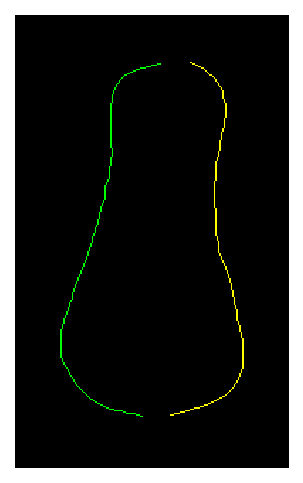

In [7]:
rdimg = imgs[0]
# 輪郭線データを左右に分割
conLeft,conRight = rd.getCntPairWithImg(rdimg,top=0.1,bottom=0.9,topCD=1.0, bottomCD=0.8,topdtopdr=10,dbtmdr=10)

canvas = cv2.cvtColor(np.zeros_like(rdimg) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0))
rd.drawContours(canvas,conRight,color=(0,255,255))
plt.figure(dpi=150)
rd.plotimg(canvas)

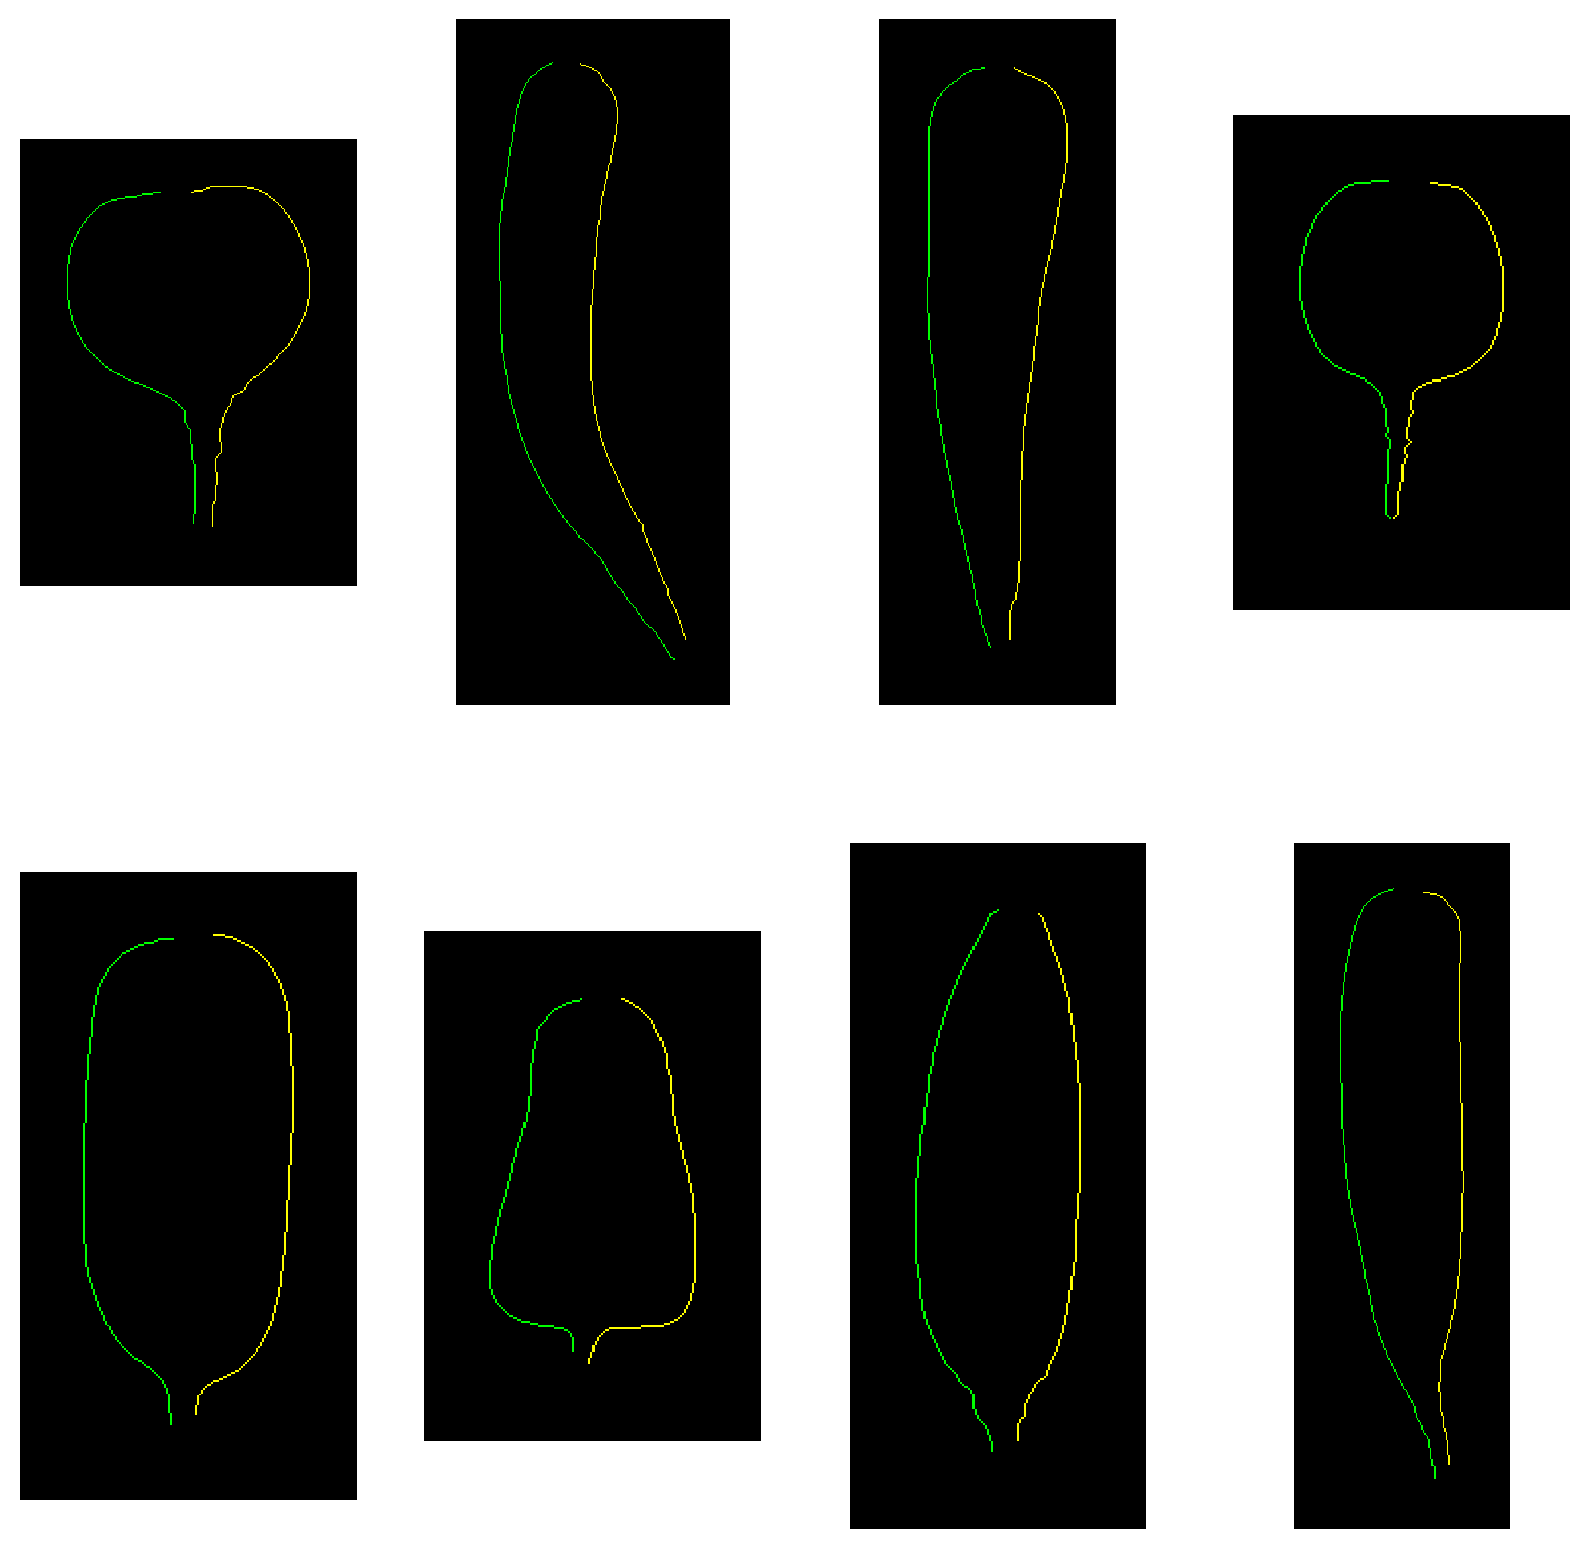

In [8]:
def getLR(rdimg,layout=111):
    # 輪郭線データを左右に分割
    conLeft,conRight = rd.getCntPairWithImg(rdimg)
    canvas = cv2.cvtColor(np.zeros_like(rdimg) ,cv2.COLOR_GRAY2BGR)
    rd.drawContours(canvas,conLeft,color=(0,255,0))
    rd.drawContours(canvas,conRight,color=(0,255,255))
    rd.plotimg(canvas,layout=layout)

plt.figure(figsize=(10,10),dpi=200)
getLR(imgs[1],layout='241')
getLR(imgs[2],layout='242')
getLR(imgs[3],layout='243')
getLR(imgs[4],layout='244')
getLR(imgs[5],layout='245')
getLR(imgs[6],layout='246')
getLR(imgs[7],layout='247')
getLR(imgs[8],layout='248')